## Notebook for analysis of allele biases

The parameters 'threshold', 'folder' and 'chromosome' can be changed manually. 

In [1]:
!pip install bioinfokit
!pip install qmplot

import math
import matplotlib.pyplot as plt
import pandas as pd
from bioinfokit import analys, visuz
from scipy.stats import binomtest 
from statsmodels.stats import multitest
from qmplot import manhattanplot

pd.set_option("display.max_columns", None)

Read thresholded dataframe with LOH positions

In [64]:
threshold = 40
folder = "LOH_pos_mmml_thresholded"
readfile = f"../{folder}/LOH_positions_threshold_{threshold}.tsv.gz"

In [65]:
df = pd.read_csv(readfile, sep="\t", compression="gzip")
len(df)

211450

In [66]:
def get_number_ref_alleles(entry: str) -> int:
    return entry.split(",")[0]

In [67]:
def get_number_alt_alleles(entry: str) -> int:
    return entry.split(",")[1]

In [68]:
# tumor_genotype field is "ref,alt"
df["n_ref_alleles"] = df["tumor_genotype"].apply(get_number_ref_alleles)
df["n_alt_alleles"] = df["tumor_genotype"].apply(get_number_alt_alleles)

In [69]:
df.head()

,#CHROM,pos_x,REF,ALT,INFO,sample_control,sample_tumor,start,end,genotype,TCN,PID,normal_genotype,tumor_genotype,quality_score,reads_normal,reads_tumor,position_code,pos_y,position_count,n_ref_alleles,n_alt_alleles
0,14,106381570,C,G,BRF=0.06;FR=0.5;HP=3;HapScore=1;MGOF=7;MMLQ=37...,"0/1:-44.79,0,-94.29:2:99:42:14","0/1:-17.7,0,-100.3:7:99:36:7",106380249,107049989,2:0,2.0,4100049,"1,1","2,0",99.000000,42.0,36,14-106381570,14-106381570,42,2,0
1,14,106381570,C,G,BRF=0.2;FR=0.75;HP=3;HapScore=1;MGOF=11;MMLQ=3...,"0/1:-53.86,0,-51.86:3:99:36:18","1/1:-70.5,-5.81,0:11:58:20:20",106350732,106552286,1:0,1.0,4100314,"1,1","0,1",99.000000,36.0,20,14-106381570,14-106381570,42,0,1
2,14,106381570,C,G,BRF=0.04;FR=0.5;HP=3;HapScore=1;MGOF=1;MMLQ=34...,"0/1:-95.59,0,-44.79:1:99:48:31","0/1:-8.78,0,-62.78:1:88:23:4",106370360,106880000,1:0,1.0,4101815,"1,1","1,0",68.389793,48.0,23,14-106381570,14-106381570,42,1,0
3,14,106381570,C,G,BRF=0.3;FR=0.5;HP=3;HapScore=2;MGOF=7;MMLQ=37;...,"0/1:-44.47,0,-60.67:3:99:34:15","0/1:-38.19,0,-4.09:7:41:14:11",106376274,107259908,1:0,1.0,4107559,"1,1","0,1",51.061773,34.0,14,14-106381570,14-106381570,42,0,1
4,14,106381570,C,G,BRF=0.21;FR=0.5;HP=3;HapScore=2;MGOF=5;MMLQ=37...,"0/1:-53.67,0,-48.67:1:99:33:18","0/1:-18.18,0,-32.88:5:99:16:6",106326601,106804973,1:0,1.0,4108988,"1,1","1,0",10.072479,33.0,16,14-106381570,14-106381570,42,1,0


In [70]:
len(df[df['n_alt_alleles']=="0"])

144601

Perform binomial test for each position

In [71]:
def get_p_value(df_position: pd.DataFrame) -> float:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_ref_alleles"] == "0"]
    k = len(df_loss_ref)
    result = binomtest(k=k, n=n, p=0.5, alternative="two-sided")
    return result.pvalue

In [72]:
p_values = df.groupby("position_code").apply(get_p_value)

Plot p-values

<Axes: title={'center': 'Distribution of p-values'}, xlabel='p-value', ylabel='Frequency'>

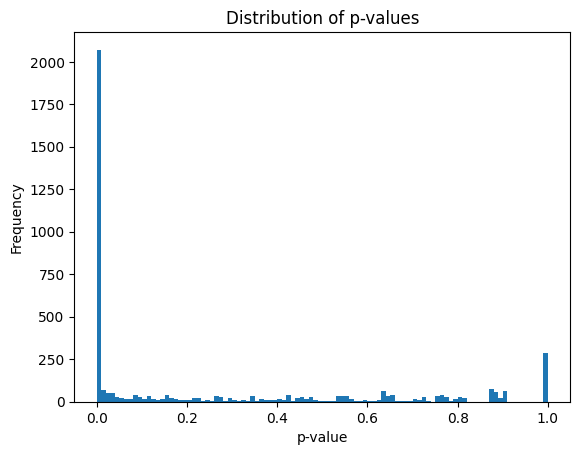

In [73]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")

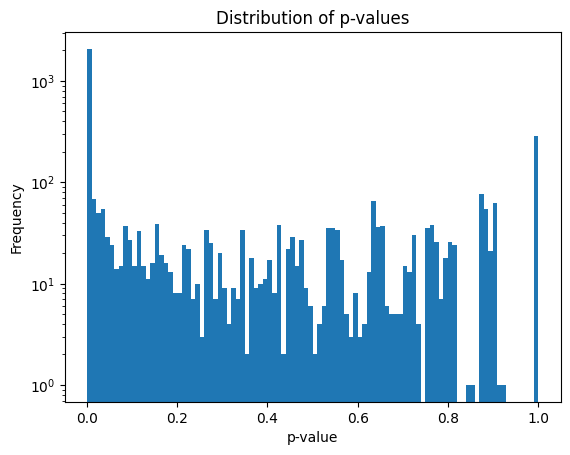

In [74]:
p_values.plot(kind="hist", bins=100, title="Distribution of p-values", xlabel="p-value")
plt.yscale("log")

Benjamini-Hochberg correction for multiple testing

In [75]:
rejected, adjusted_p_values, _, _ = multitest.multipletests(p_values, method='fdr_bh')

Text(0.5, 1.0, 'Distribution of p-values (adjusted by Benjamini-Hochberg correction)')

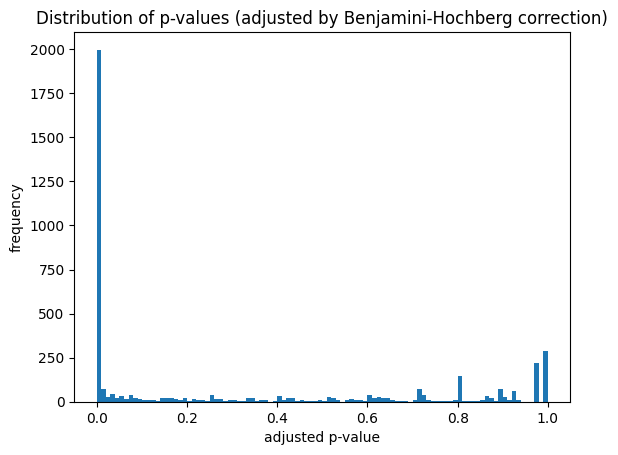

In [76]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")

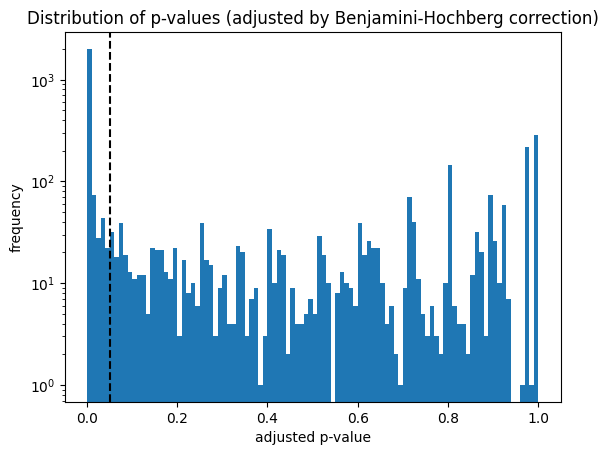

In [77]:
plt.hist(adjusted_p_values, bins=100)
plt.xlabel("adjusted p-value")
plt.ylabel("frequency")
plt.title("Distribution of p-values (adjusted by Benjamini-Hochberg correction)")
plt.yscale("log")
plt.axvline(x=0.05, linestyle="dashed", color="black")

Visualisation: Manhattan plot

In [78]:
df_manhattan = pd.DataFrame(p_values).reset_index()
df_manhattan["P"] = adjusted_p_values
df_manhattan[["#CHROM", "POS"]] = df_manhattan["position_code"].str.split("-", expand=True)
df_manhattan = df_manhattan.rename(columns={0: "p_val", "position_code": "ID"})
df_manhattan = df_manhattan[["#CHROM", "POS", "P", "ID"]]
df_manhattan.head()

,#CHROM,POS,P,ID
0,1,10028619,3.789450e-06,1-10028619
1,1,1004126,6.588639e-12,1-1004126
2,1,1004180,8.969653e-06,1-1004180
3,1,1004201,2.108533e-01,1-1004201
4,1,1004203,1.244828e-01,1-1004203


In [79]:
df_manhattan["#CHROM"] = df_manhattan["#CHROM"].astype(int)
df_manhattan["POS"] = df_manhattan["POS"].astype(int)
df_manhattan["ID"] = df_manhattan["ID"].astype(str)
df_manhattan = df_manhattan.sort_values(by=["#CHROM", "POS"])
df_manhattan.tail()

,#CHROM,POS,P,ID
3538,17,6931807,0.002053,17-6931807
3539,17,7205837,0.423036,17-7205837
3540,17,7205838,0.615614,17-7205838
3541,17,7205843,0.423036,17-7205843
3542,22,23217657,0.005463,22-23217657


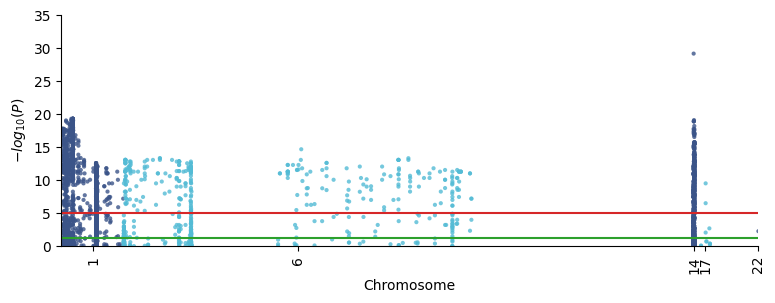

In [80]:
ax = manhattanplot(
    data=df_manhattan,
    genomewideline=0.05,
    xticklabel_kws={"rotation": "vertical"})

Zoom in on chromosomes

In [81]:
chromosome = 1

In [82]:
df_chrom = df_manhattan[df_manhattan["#CHROM"] == str(chromosome)]
len(df_chrom)

2046

/home/frajonas/miniconda3/lib/python3.10/site-packages/qmplot/modules/_manhattan.py:239: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[[chrom]] = data[[chrom]].astype(str)  # make sure all the chromosome id are character.
/home/frajonas/miniconda3/lib/python3.10/site-packages/qmplot/modules/_manhattan.py:320: RuntimeWarning: divide by zero encountered in log10
  ax.axhline(y=-np.log10(suggestiveline) if logp else suggestiveline, color=sign_line_cols[0], **hline_kws)


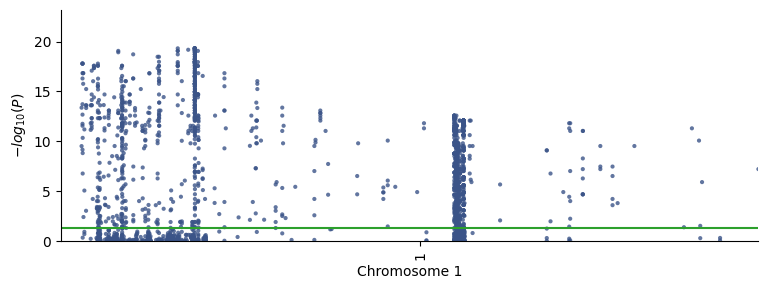

In [83]:
ax = manhattanplot(
    data=df_chrom,
    xticklabel_kws={"rotation": "vertical"}, 
    genomewideline=0.05,
    is_annotate_topsnp=True,
    suggestiveline=False,
    xlabel=f"Chromosome {chromosome}")

Get genomic region on chromosomes

In [84]:
df_region = df_manhattan[df_manhattan["#CHROM"] == str(chromosome)]
df_region = df_region[df_region["P"] < 0.05]
min_pos = df_region["POS"].min()
max_pos = df_region["POS"].max()

In [85]:
min_pos, max_pos

(884090, 29845269)

Volcano plot

In [86]:
def get_log_score(df_position: pd.DataFrame) -> float:
    n = len(df_position)
    df_loss_ref = df_position[df_position["n_ref_alleles"] == "0"]
    ref = len(df_loss_ref)
    alt = n - ref
    if alt == 0:
        # set alt to 0.001, so that calculation is possible
        log_score = math.log10(ref / 0.1)
    elif ref == 0:
        # set ref to 0.001, so that calculation is possible
        log_score = math.log10(0.1 / alt)
    else:
        log_score = math.log10(ref / alt)
    return log_score

In [87]:
log_scores = df.groupby("position_code").apply(get_log_score)

In [88]:
log_scores

position_code
1-10028619   -0.845098
1-1004126    -1.389166
1-1004180     0.669007
1-1004201    -0.204120
1-1004203    -0.239760
                ...   
6-97430944   -1.146128
6-97431469   -1.707570
6-97431473   -1.707570
6-994249     -2.612784
6-994472     -2.612784
Length: 4092, dtype: float64

In [89]:
df_volcano = pd.DataFrame(p_values).reset_index()
df_volcano["log_score"] = log_scores.values
df_volcano["adjusted p_val"] = adjusted_p_values
df_volcano = df_volcano.rename(columns={0: "p_value"})
df_volcano.head()

,position_code,p_value,log_score,adjusted p_val
0,1-10028619,1.382612e-06,-0.845098,3.789450e-06
1,1-1004126,1.178613e-12,-1.389166,6.588639e-12
2,1-1004180,3.388828e-06,0.669007,8.969653e-06
3,1-1004201,1.263471e-01,-0.204120,2.108533e-01
4,1-1004203,7.039422e-02,-0.239760,1.244828e-01


In [90]:
df_volcano = df_volcano.dropna(axis=0, subset=["log_score"])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

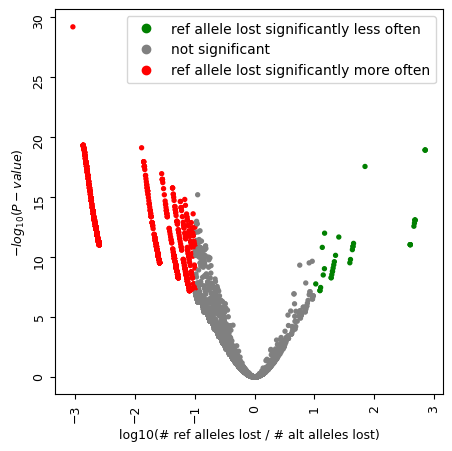

: 

In [91]:
visuz.GeneExpression.volcano(df=df_volcano, lfc='log_score', pv='adjusted p_val', show=True, axxlabel="log10(# ref alleles lost / # alt alleles lost)", plotlegend=True, legendlabels=["ref allele lost significantly less often", "not significant", "ref allele lost significantly more often"])